In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append('/dfs/scratch0/vschen/metal')

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def visualize_data(X, Y, C, L):
    # show data by class
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 2, 1)
    plt.title('Data by Classes')
    plt.scatter(X[Y==1,0], X[Y==1,1], label="$y=+1$", c='C1')
    plt.scatter(X[Y==-1,0], X[Y==-1,1], label="$y=-1$", c='C0')
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)
    plt.legend()

    # show data by slice
    plt.subplot(2, 2, 2)
    plt.title('Data by Slice')
    plt.scatter(X[C==0,0], X[C==0,1], label="$S_0$", c='C0')
    plt.scatter(X[C==1,0], X[C==1,1], label="$S_1$", c='C1')
    plt.scatter(X[C==2,0], X[C==2,1], label="$S_2$", c='C2')
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)
    plt.legend()

    # LFs targeting slices
    plt.subplot(2, 2, 3)
    plt.title('LFs ($\lambda_i$) Targeting Slices ($S_i$)')
    plt.scatter(X[L[:,0]!=0,0], X[L[:,0]!=0,1], label="$\lambda_0$", c='C0')
    plt.scatter(X[L[:,1]!=0,0], X[L[:,1]!=0,1], label="$\lambda_1$", c='C1')
    plt.scatter(X[L[:,2]!=0,0], X[L[:,2]!=0,1], label="$\lambda_2$", c='C2')
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.title('$\lambda_2$ votes')
    # first plot underlying slice
    plt.scatter(X[C==2,0], X[C==2,1], label="$S_2$", s=0.1, c='red')
    plt.scatter(X[L[:,2]==1,0], X[L[:,2]==1,1], label="$\lambda_2=+1$", s=0.2, c='C1')
    plt.scatter(X[L[:,2]==-1,0], X[L[:,2]==-1,1], label="$\lambda_2=-1$", s=0.2, c='C0')    
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)
    plt.legend()
    plt.show()


## Simulate

target recall: 0.9, found cov: 0.9, found r: 3.749999999999964
target recall: 0.9, found cov: 0.9001607952053793, found r: 4.87999999999994
target recall: 0.4, found cov: 0.40212443095599393, found r: 0.6300000000000003


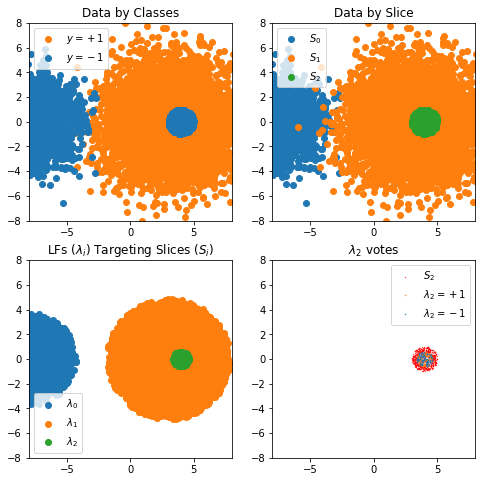

{'N': 10000,
 'mus': [array([-8,  0]), array([3, 0])],
 'labels': [-1, 1],
 'props': [0.25, 0.75],
 'variances': [3, 5],
 'head_config': {'h': 4, 'k': 0, 'r': 1, 'slice_label': -1},
 'accs': array([0.9, 0.9, 0.4]),
 'covs': [('recall', 0.9), ('recall', 0.9), ('recall', 0.4)]}

In [24]:
from simulate import data_config as config
from synthetics_utils import generate_synthetic_data

X, Y, C, L = generate_synthetic_data(config, 'cov.recall', 0.4)
visualize_data(X, Y, C, L)
config

In [ ]:
from simulate import eval_model
def eval_on_slices(model, X_test, Y_test, C_test):
    S0_idx, S1_idx, S2_idx = (
        np.where(C_test == 0)[0],
        np.where(C_test == 1)[0],
        np.where(C_test == 2)[0],
    )
    eval_dict = {"S0": S0_idx, "S1": S1_idx, "S2": S2_idx}

    preds, Y = model._get_predictions((X_test, Y_test), return_probs=False)
    
    print ("S0:", np.sum((preds == Y)[S0_idx]) / len(Y[S0_idx]))
    print ("S1:", np.sum((preds == Y)[S1_idx]) / len(Y[S1_idx]))
    print ("S2:", np.sum((preds == Y)[S2_idx]) / len(Y[S2_idx]))
    

split_idx = int(len(X) * 0.8)

X = torch.Tensor(X)
# X = X.astype(np.float32)
Y_cat = Y.copy().astype(np.int32)
Y_cat[Y==-1] = 2
X_train, X_test = X[:split_idx], X[split_idx:]
Y_train, Y_test = Y_cat[:split_idx], Y_cat[split_idx:]
L_train, L_test = L[:split_idx], L[split_idx:]
C_train, C_test = C[:split_idx], C[split_idx:]

In [ ]:
from metal.label_model import LabelModel
label_model = LabelModel(k=2, seed=123)
L_train[L_train==-1] = 2
label_model.train_model(L_train, n_epochs=500, print_every=25)
score = label_model.score((L_test, Y_test))
Y_tilde = label_model.predict_proba(L_train)

In [ ]:
from metal.end_model import EndModel
end_model = EndModel([2,10,10,10,10,2], seed=123) # seed = 123
end_model.train_model(
    (X_train, Y_tilde), 
    dev_data=(X_test, Y_test), 
    lr=0.005,
    n_epochs=20,
    disable_prog_bar=True
)

eval_on_slices(end_model, X_test, Y_test, C_test)

In [ ]:
from torch.utils.data import Dataset
class SyntheticSliceDatset(Dataset):
    def __init__(self, X, L, Y_tilde):
        self.X = X
        if 2 in np.unique(L):
            L[L==2] = -1
        self.L = L.astype(np.float32)
        self.Y_tilde = Y_tilde.astype(np.float32)

    def __getitem__(self, idx):
        return (self.X[idx], self.L[idx], self.Y_tilde[idx])
    
    def __len__(self):
        return len(self.X)
    
train_dataset = SyntheticSliceDatset(X_train, L_train, Y_tilde)

In [ ]:
# uniform
from metal.contrib.slicing.online_dp import MLPModule, SliceDPModel

input_module_class = MLPModule
init_kwargs = {
   'input_dim': 2,
    'middle_dims': [10, 10],
   'bias': True
 }

accs = config['accs']
r = 10
init_kwargs.update({"output_dim": r})
slice_model = SliceDPModel(
    input_module_class(**init_kwargs),
    accs,
    r=r,
    reweight=False,
    slice_weight=0.5,
)

slice_model.train_model(
    train_dataset, 
    dev_data=(X_test, Y_test), 
    lr=0.005,
    n_epochs=20,
    disable_prog_bar=True,
#     print_every=1,
    checkpoint_runway=5
)

print(eval_on_slices(slice_model, X_test, Y_test, C_test))

In [ ]:
# manual
from metal.contrib.slicing.online_dp import MLPModule, SliceDPModel

input_module_class = MLPModule
init_kwargs = {
   'input_dim': 2,
    'middle_dims': [10, 10],
   'bias': True
 }

accs = config['accs']

# weights for manual reweighting case
weights = np.ones(3, dtype=np.float32)
weights[-1] = 5.0

r = 10
init_kwargs.update({"output_dim": r})
slice_model = SliceDPModel(
    input_module_class(**init_kwargs),
    accs,
    r=r,
    reweight=False,
    slice_weight=0.5,
    L_weight=weights
)

slice_model.train_model(
    train_dataset, 
    dev_data=(X_test, Y_test), 
    lr=0.005,
    n_epochs=20,
    disable_prog_bar=True,
    print_every=1,
    checkpoint_runway=5
)

eval_on_slices(slice_model, X_test, Y_test, C_test)

In [ ]:
# attention
from metal.contrib.slicing.online_dp import MLPModule, SliceDPModel

input_module_class = MLPModule
init_kwargs = {
   'input_dim': 2,
    'middle_dims': [10, 10],
   'bias': True
 }

accs = config['accs']

r = 10
init_kwargs.update({"output_dim": r})
slice_model = SliceDPModel(
    input_module_class(**init_kwargs),
    accs,
    r=r,
    reweight=True,
    slice_weight=0.5
)

slice_model.train_model(
    train_dataset,
#     (X_train, L_train), 
    dev_data=(X_test, Y_test), 
    lr=0.005,
    n_epochs=20,
    disable_prog_bar=True,
    print_every=1,
    checkpoint_runway=5
)

eval_on_slices(slice_model, X_test, Y_test, C_test)

In [ ]:
# %%time
from simulate import simulate, data_config, experiment_config

experiment_config['x_var'] = 'cov.precision'
experiment_config['num_trials'] = 1
# experiment_config['x_range'] = np.linspace(0.55, 0.95, 5)
experiment_config['x_range'] = [0.5, 0.6, 0.7, 0.8, 0.9]
experiment_config["train_kwargs"]['verbose'] = True
experiment_config["train_kwargs"]['print_every'] = 10

baseline_scores, manual_scores, attention_scores = \
    simulate(config, generate_synthetic_data, experiment_config)

  0%|          | 0/1 [00:00<?, ?it/s]

Simulating: cov.precision=0.5
target recall: 0.9, found cov: 0.9, found r: 3.699999999999965
target recall: 0.9, found cov: 0.9011602291085328, found r: 4.859999999999941
target precision: 0.5, found cov: 0.49483204134366926, found r: 1
No checkpoints will be saved in the first checkpoint_runway=5 iterations.
[E:0]	Train Loss: 0.017	Dev accuracy: 0.918
Saving model at iteration 5 with best score 0.907
Saving model at iteration 6 with best score 0.912
[E:10]	Train Loss: 0.015	Dev accuracy: 0.910
Saving model at iteration 15 with best score 0.923
[E:19]	Train Loss: 0.015	Dev accuracy: 0.908
Restoring best model from iteration 15 with score 0.923
Finished Training
Accuracy: 0.923
        y=1    y=2   
 l=1   1334    143   
 l=2    11     512   
No checkpoints will be saved in the first checkpoint_runway=5 iterations.
[E:0]	Train Loss: 0.020	Dev accuracy: 0.925
Saving model at iteration 5 with best score 0.905
Saving model at iteration 6 with best score 0.918
[E:10]	Train Loss: 0.019	Dev a

  0%|          | 0/1 [00:00<?, ?it/s]

Simulating: cov.precision=0.6
target recall: 0.9, found cov: 0.9, found r: 3.6899999999999653
target recall: 0.9, found cov: 0.9005967108135643, found r: 4.9699999999999385
target precision: 0.6, found cov: 0.5905172413793104, found r: 1
No checkpoints will be saved in the first checkpoint_runway=5 iterations.
[E:0]	Train Loss: 0.017	Dev accuracy: 0.932
Saving model at iteration 5 with best score 0.931
[E:10]	Train Loss: 0.015	Dev accuracy: 0.928
[E:19]	Train Loss: 0.015	Dev accuracy: 0.916
Restoring best model from iteration 5 with score 0.931
Finished Training
Accuracy: 0.931
        y=1    y=2   
 l=1   1341    126   
 l=2    12     521   
No checkpoints will be saved in the first checkpoint_runway=5 iterations.
[E:0]	Train Loss: 0.020	Dev accuracy: 0.929
Saving model at iteration 5 with best score 0.922


In [ ]:
def get_slice_scores(scores, key=0.9):
    S0 = np.mean([s['S0'] for s in scores[key]])
    S1 = np.mean([s['S1'] for s in scores[key]])
    S2 = np.mean([s['S2'] for s in scores[key]])
    overall = np.mean([s['overall'] for s in scores[key]])    
    return {'S0':S0, 'S1':S1, 'S2':S2, 'overall':overall}

In [ ]:
for k in baseline_scores.keys():
    print (k)
    print ('base:', get_slice_scores(baseline_scores, k))
    print ('manual:', get_slice_scores(manual_scores, k))
    print ('attention:', get_slice_scores(attention_scores, k))

In [ ]:
results = {
    'baseline': dict(baseline_scores),
    'manual': dict(manual_scores),
    'attention': dict(attention_scores)
}

from synthetics_utils import plot_slice_scores
xlabel="Head LF ($\lambda_2$) Accuracy"
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plot_slice_scores(results, "S2", xlabel=xlabel)
plt.subplot(2, 2, 2)
plot_slice_scores(results, "S1", xlabel=xlabel)
plt.subplot(2, 2, 3)
plot_slice_scores(results, "S0", xlabel=xlabel)
plt.subplot(2, 2, 4)
plot_slice_scores(results, "overall", xlabel=xlabel)